In [ ]:
from mcp import ClientSession, StdioServerParameters
from mcp.client.stdio import stdio_client
from langchain_mcp_adapters.tools import load_mcp_tools
from langgraph.prebuilt import create_react_agent
from langchain_openai import ChatOpenAI
from utils import astream_graph


llm = ChatOpenAI(
    base_url="http://localhost:11434/v1",
    api_key="ollama",
    model="midm-2.0-base-q8",
    temperature=0.1,  # 0.0에서 0.1로 변경
    max_tokens=8192,
)


# StdIO 서버 파라미터 설정
# - command: Python 인터프리터 경로
# - args: 실행할 MCP 서버 스크립트
server_params = StdioServerParameters(
    command="python",
    args=["servers/user_assessment.py"],
)

# StdIO 클라이언트를 사용하여 서버와 통신
async with stdio_client(server_params) as (read, write):
    # 클라이언트 세션 생성
    async with ClientSession(read, write) as session:
        # 연결 초기화
        await session.initialize()

        # MCP 도구 로드
        tools = await load_mcp_tools(session)
        print(f"Loaded MCP tools count: {len(tools)}")
        print("Tools:", [tool.name for tool in tools])

        # 에이전트 생성
        agent = create_react_agent(llm, tools)

        # 에이전트 응답 스트리밍
        # await astream_graph(agent, {"messages": [("user", "dh")]})
        await astream_graph(agent, {"messages": "오늘 날씨 어때"})

Loaded MCP tools count: 1
Tools: ['get_weather']

🔄 Node: agent 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 

🔄 Node: tools 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
It's always Sunny in 서울
🔄 Node: agent 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
오늘 서울은 항상 화창하네요! 맑은 하늘을 볼 수 있을 것 같아요. 날씨가 좋으니 기분도 상쾌하실 거예요.

In [12]:
from mcp import ClientSession, StdioServerParameters
from mcp.client.stdio import stdio_client
from langchain_mcp_adapters.tools import load_mcp_tools
from langgraph.prebuilt import create_react_agent
from langchain_openai import ChatOpenAI
from utils import astream_graph

llm = ChatOpenAI(
    base_url="http://localhost:11434/v1",
    api_key="ollama",
    model="midm-2.0-base-q8",
    temperature=0.1,
    max_tokens=8192,
)

# 여러 MCP 서버 동시 연결
server_scripts = [
    "servers/user_assessment.py",
    "servers/generate_curriculum.py",
    "servers/evaluate_user.py"
]

sessions = []
stdio_clients = []
all_tools = []


# 각 서버별로 연결
for server_script in server_scripts:
    server_params = StdioServerParameters(
        command="python",
        args=[server_script],
    )

    # StdIO 클라이언트 생성
    stdio_client_instance = stdio_client(server_params)
    read, write = await stdio_client_instance.__aenter__()

    # 세션 생성
    session = ClientSession(read, write)
    await session.__aenter__()
    await session.initialize()

    # 저장 (나중에 정리하기 위해)
    stdio_clients.append(stdio_client_instance)
    sessions.append(session)

    # 해당 서버의 도구 로드
    tools = await load_mcp_tools(session)
    all_tools.extend(tools)
    print(f"Loaded {len(tools)} tools from {server_script}: {[t.name for t in tools]}")

print(f"Total tools loaded: {len(all_tools)}")

# 모든 도구로 에이전트 생성
agent = create_react_agent(llm, all_tools)

# 사용자 질문으로 테스트
await astream_graph(agent, {"messages": "오늘 날씨 어떄 ?"})


Loaded 1 tools from servers/user_assessment.py: ['user_profiling']
Loaded 1 tools from servers/generate_curriculum.py: ['get_weather']
Loaded 1 tools from servers/evaluate_user.py: ['get_weather']
Total tools loaded: 3

🔄 Node: agent 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 

🔄 Node: tools 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
It's always Sunny in 서울
🔄 Node: agent 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
오늘 서울은 항상 맑아요! 날씨가 정말 좋네요. 혹시 오늘 특별히 계획하고 계신 일 있으세요?

{'node': 'agent',
 'content': AIMessageChunk(content='', additional_kwargs={}, response_metadata={'finish_reason': 'stop', 'model_name': 'midm-2.0-base-q8', 'system_fingerprint': 'fp_ollama'}, id='run--92518610-8f53-4108-a8f7-9f903517ba3d'),
 'metadata': {'langgraph_step': 3,
  'langgraph_node': 'agent',
  'langgraph_triggers': ('branch:to:agent',),
  'langgraph_path': ('__pregel_pull', 'agent'),
  'langgraph_checkpoint_ns': 'agent:77b190fc-e06b-c14d-b065-7cda89ddf209',
  'checkpoint_ns': 'agent:77b190fc-e06b-c14d-b065-7cda89ddf209',
  'ls_provider': 'openai',
  'ls_model_name': 'midm-2.0-base-q8',
  'ls_model_type': 'chat',
  'ls_temperature': 0.1,
  'ls_max_tokens': 8192}}

In [16]:
prompt = "나는 파이썬 배우고 싶어"
await astream_graph(agent, {"messages": prompt})


🔄 Node: agent 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
파이썬을 배우고 싶으시군요! 프로그래밍 언어 중에서도 파이썬은 초보자에게 매우 인기 있는 언어예요. 어떤 부분에 특히 관심이 있으신가요? 웹 개발, 데이터 분석, 인공지능 등 구체적인 분야가 있으시면 알려주세요.

{'node': 'agent',
 'content': AIMessageChunk(content='', additional_kwargs={}, response_metadata={'finish_reason': 'stop', 'model_name': 'midm-2.0-base-q8', 'system_fingerprint': 'fp_ollama'}, id='run--c52fccf6-2ef1-4204-b859-1f4d6fc933a7'),
 'metadata': {'langgraph_step': 1,
  'langgraph_node': 'agent',
  'langgraph_triggers': ('branch:to:agent',),
  'langgraph_path': ('__pregel_pull', 'agent'),
  'langgraph_checkpoint_ns': 'agent:05101a74-9377-e1ce-6bb7-f3ffbe6ff03f',
  'checkpoint_ns': 'agent:05101a74-9377-e1ce-6bb7-f3ffbe6ff03f',
  'ls_provider': 'openai',
  'ls_model_name': 'midm-2.0-base-q8',
  'ls_model_type': 'chat',
  'ls_temperature': 0.1,
  'ls_max_tokens': 8192}}

In [3]:
async def test_tool_call(self):
    """툴 직접 호출 테스트"""
    tools = await load_mcp_tools(self.session)
    for tool in tools:
        if tool.name == "user_profiling":
            result = await tool.ainvoke({"message": "파이썬 배우고 싶어요"})
            print(f"툴 직접 호출 결과: {result}")
            return result

/opt/anaconda3/envs/kt_competition/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mermaid.ink'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


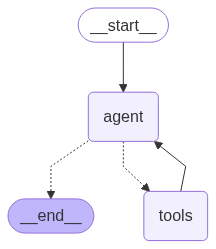

In [ ]:
from IPython.display import Image, display

try:
    display(Image(agent.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    pass

In [4]:
# user_assessment.py에 로그 추가
from mcp.server.fastmcp import FastMCP
import logging
import sys

# 로깅 설정
logging.basicConfig(
    level=logging.DEBUG,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.StreamHandler(sys.stdout)
    ]
)
logger = logging.getLogger(__name__)

mcp = FastMCP(
    "UserProfiling",  # 이름 변경
    instructions="You are a learning mentor that profiles users for personalized education.",
    host="0.0.0.0",
    port=8005,
)

@mcp.tool()
async def user_profiling(message: str) -> str:
    logger.info(f"user_profiling 툴 호출됨! 메시지: {message}")
    
    result = "파이썬 학습에 관심이 있으시군요! 몇 가지 질문드릴게요."
    
    logger.info(f"응답: {result}")
    return result

if __name__ == "__main__":
    logger.info("MCP 서버 시작...")
    mcp.run(transport="stdio")

2025-09-05 21:03:57,580 - mcp.server.lowlevel.server - DEBUG - Initializing server 'UserProfiling'
2025-09-05 21:03:57,581 - mcp.server.lowlevel.server - DEBUG - Registering handler for ListToolsRequest
2025-09-05 21:03:57,582 - mcp.server.lowlevel.server - DEBUG - Registering handler for CallToolRequest
2025-09-05 21:03:57,582 - mcp.server.lowlevel.server - DEBUG - Registering handler for ListResourcesRequest
2025-09-05 21:03:57,583 - mcp.server.lowlevel.server - DEBUG - Registering handler for ReadResourceRequest
2025-09-05 21:03:57,583 - mcp.server.lowlevel.server - DEBUG - Registering handler for PromptListRequest
2025-09-05 21:03:57,584 - mcp.server.lowlevel.server - DEBUG - Registering handler for GetPromptRequest
2025-09-05 21:03:57,585 - mcp.server.lowlevel.server - DEBUG - Registering handler for ListResourceTemplatesRequest
2025-09-05 21:03:57,594 - __main__ - INFO - MCP 서버 시작...


RuntimeError: Already running asyncio in this thread